Name - Y.H.A.Epa

Index Number - 190166V

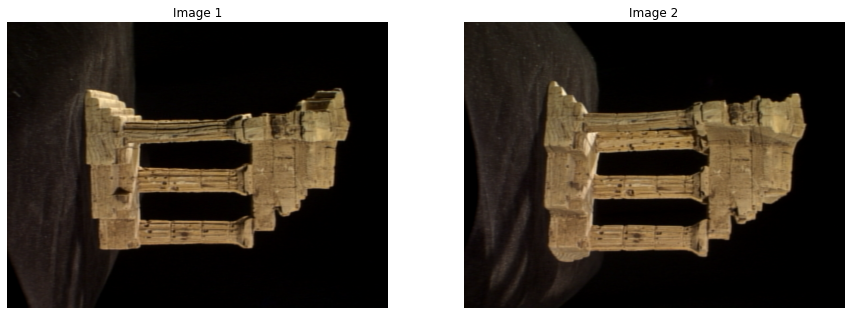

In [8]:
#Question 1
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

f = open("templeSR_par.txt",'r')
assert f is not None

n = int(f.readline())

#Reading the information on the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Reading the information on the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 = cv.imread(im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cv.cvtColor(im1,cv.COLOR_BGR2RGB))
ax[0].axis("off")
ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(im2,cv.COLOR_BGR2RGB))
ax[1].axis("off")
ax[1].set_title("Image 2")
plt.show()

In [9]:
#Question 2
P1 = K1 @ np.hstack((R1,t1)) # P = K*[R|t]
P2 = K2 @ np.hstack((R2,t2)) # P = K*[R|t]
print("P1 =", P1)
print("P2 =", P2)

P1 = [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 = [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


F = [[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


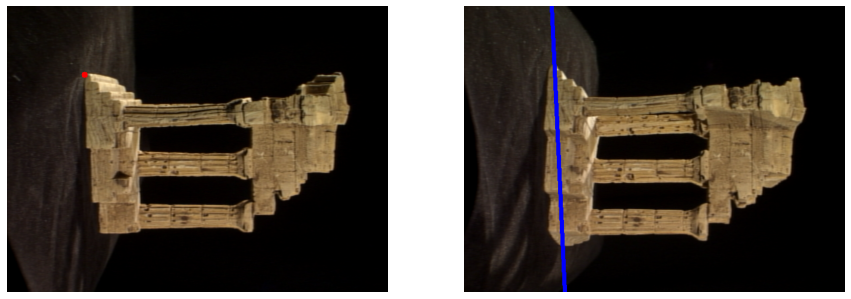

In [10]:
#Question 3
from scipy.linalg import null_space
def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

C = null_space(P1)
C = C*np.sign(C[0,0])
e2 = P2 @ C
e2x = skew(e2)
F = e2x @ P2 @ np.linalg.pinv(P1)
print("F =", F)

x = np.array([130, 115, 1])
cv.circle(im1, (x[0],x[1]),5,(0,0,255),-1)

l2 = F @ x.T
p1 = np.array([0,(l2[0]*0 +l2[2])/l2[1]]).astype(int)
p2 = np.array([500,(l2[0]*500 +l2[2])/l2[1]]).astype(int)
cv.line(im2, (p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cv.cvtColor(im1,cv.COLOR_BGR2RGB))
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(im2,cv.COLOR_BGR2RGB))
ax[1].axis("off")
plt.show()

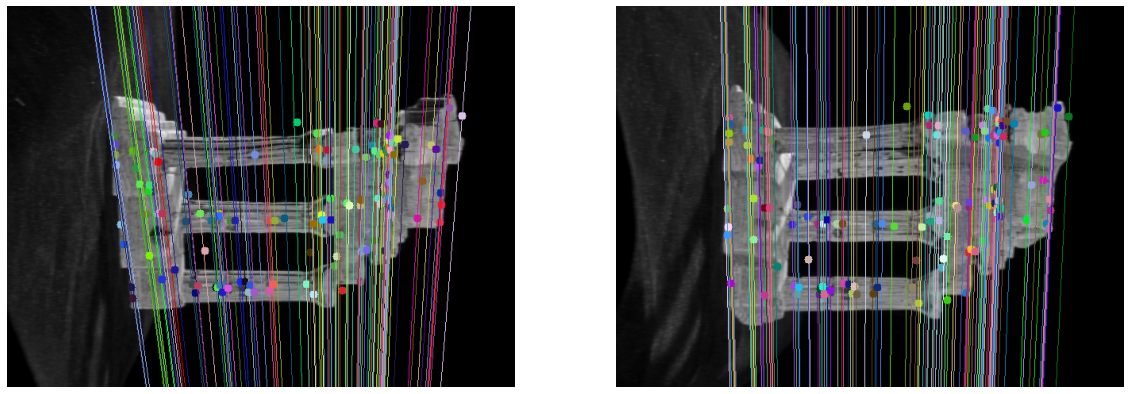

In [5]:
#Question 4
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

im1 = cv.imread("templeSR0001.png", 0)
im2 = cv.imread("templeSR0002.png", 0)
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(im1, im2, lines, pts1, pts2):
    r, c = im1.shape
    im1 = cv.cvtColor(im1, cv.COLOR_GRAY2BGR)
    im2 = cv.cvtColor(im2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0,-r[2]/r[1]])
        x1, y1 = map(int, [c,-(r[2]+r[0]*c)/r[1]])
        im1 = cv.line(im1, (x0,y0), (x1,y1),color,1)
        im1 = cv.circle(im1, tuple(pt1),5,color,-1)
        im2 = cv.circle(im2, tuple(pt2),5,color,-1)
    return im1, im2

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2),2,F)
lines1 = lines1.reshape(-1,3)
im5, im6 = drawlines(im1, im2, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2),1,F)
lines2 = lines2.reshape(-1,3)
im3, im4 = drawlines(im2, im1, lines2, pts2, pts1)

plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im5)
plt.axis("off")
plt.subplot(122)
plt.imshow(im3)
plt.axis("off")
plt.show()